## Robustness Against Random Failures

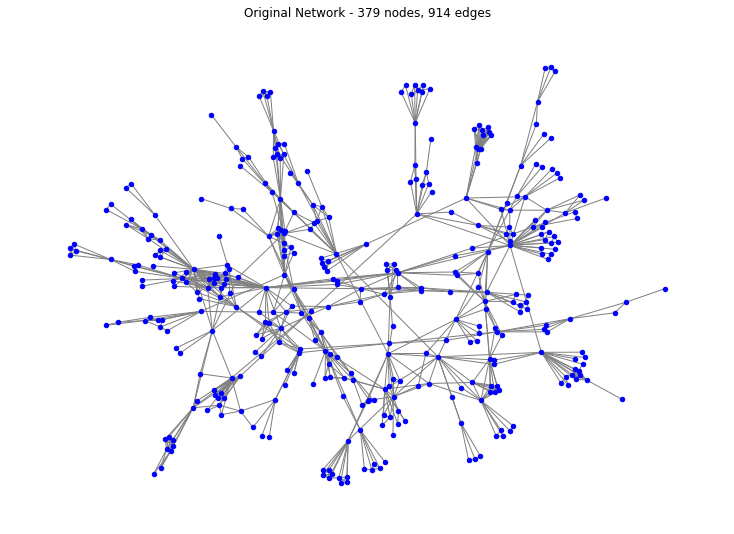

In [11]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Load the network
file_path = 'netscience.mtx'

G = nx.read_adjlist(file_path, nodetype=int)

# Convert to undirected graph if not
if G.is_directed():
    G = G.to_undirected()

# Get basic information about the network
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

num_nodes, num_edges


# Visualize the initial network
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=False, node_size=20, node_color='blue', edge_color='grey')
plt.title(f"Original Network - {initial_num_nodes} nodes, {initial_num_edges} edges")
plt.show()


The given network has 379 nodes and 914 edges. Now, let’s proceed by creating a randomized version of the network. The randomized version will have the same number of nodes and edges but with randomly assigned connections between the nodes. One way to achieve this is by using a configuration model, which preserves the degree distribution of the original network. 

In [12]:
# Generate a randomized version of the network using the configuration model
degree_sequence = [d for n, d in G.degree()]  # Degree sequence of original network
random_G = nx.configuration_model(degree_sequence, seed=42)  # Create randomized network
random_G = nx.Graph(random_G)  # Remove parallel edges
random_G.remove_edges_from(nx.selfloop_edges(random_G))  # Remove self-loops

# Check the number of nodes and edges in the randomized network
random_num_nodes = random_G.number_of_nodes()
random_num_edges = random_G.number_of_edges()

random_num_nodes, random_num_edges


(379, 903)

The randomized network has 379 nodes and 903 edges. The number of edges is slightly less than the original due to the removal of parallel edges and self-loops in the randomized network generated by the configuration model. Now, let's proceed with the robustness evaluation.

We will randomly remove nodes from both networks and at each step, compute and plot the size of the largest connected component (giant component) as a fraction of the initial network size. We will then present the plots for comparison.

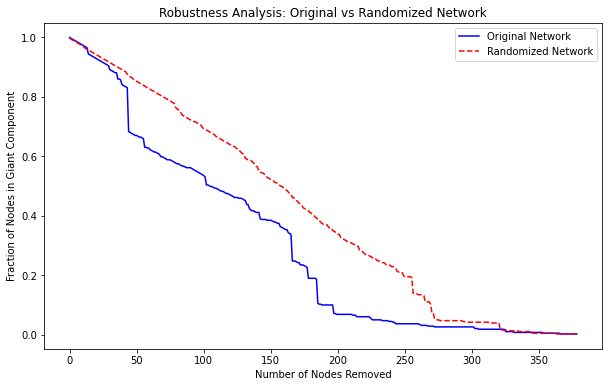

In [13]:
def robustness_analysis(graph, num_steps):
    """
    Perform robustness analysis on a given graph by randomly removing nodes and calculating
    the size of the largest connected component at each step.
    """
    # Clone the input graph to avoid modifying the original graph
    G = graph.copy()
    
    # Initial number of nodes
    initial_num_nodes = G.number_of_nodes()
    
    # List to store the fraction of nodes in the giant component at each step
    giant_component_fractions = []
    
    # Randomly remove nodes and compute the giant component size at each step
    for step in range(num_steps):
        # Compute and store the fraction of nodes in the giant component
        largest_cc = max(nx.connected_components(G), key=len)
        giant_component_fractions.append(len(largest_cc) / initial_num_nodes)
        
        # Randomly select a node and remove it from the graph
        random_node = np.random.choice(G.nodes)
        G.remove_node(random_node)
        
        # Break if the graph is empty
        if G.number_of_nodes() == 0:
            break
    
    return giant_component_fractions

# Number of steps for the robustness analysis
num_steps = min(num_nodes, random_num_nodes)

# Perform robustness analysis on both the original and randomized networks
original_robustness = robustness_analysis(G, num_steps)
randomized_robustness = robustness_analysis(random_G, num_steps)

# Create a plot for comparison
plt.figure(figsize=(10, 6))
plt.plot(original_robustness, label="Original Network", color='blue')
plt.plot(randomized_robustness, label="Randomized Network", color='red', linestyle='dashed')
plt.xlabel("Number of Nodes Removed")
plt.ylabel("Fraction of Nodes in Giant Component")
plt.title("Robustness Analysis: Original vs Randomized Network")
plt.legend()
plt.show()


The plot shows the robustness analysis of the original network (in blue) compared to its randomized version (in red). The x-axis represents the number of nodes removed from each network, while the y-axis represents the fraction of nodes in the giant component (largest connected component).

Observations:
Original Network: The original network maintains a relatively large giant component until a significant number of nodes are removed. This suggests that the network is quite robust to random failures.

Randomized Network: The randomized network's giant component decreases more sharply as nodes are removed. It seems to be less robust to random failures compared to the original network.

Analysis:
The original network likely has a structure that makes it more resilient to random node removals, such as a high clustering coefficient or well-connected hubs that keep the network connected.
The randomized network, with its connections assigned at random, may lack these structural features that contribute to robustness.

Conclusion:
Understanding the specific topological properties of the original network (like degree distribution, clustering coefficient, and betweenness centrality) would provide deeper insights into why it exhibits greater robustness compared to its randomized counterpart. The observed difference in robustness could be attributed to the inherent structural properties that are lost during the randomization process.

## Community Detection & Analysis

In [14]:
from networkx.algorithms import community

def best_partition_girvan_newman(graph):
    """
    Find the best partition into communities using the Girvan-Newman algorithm.
    Return the number of communities and the modularity of the best partition.
    """
    # Compute the communities using the Girvan-Newman algorithm
    community_generator = community.girvan_newman(graph)
    
    # Variable to store the best modularity and corresponding number of communities
    best_modularity = -1.0
    best_num_communities = 0
    
    # Iterate over partitions produced by the Girvan-Newman algorithm
    for i, partition in enumerate(community_generator):
        # Calculate the modularity of the current partition
        current_modularity = community.modularity(graph, partition)
        
        # Update the best modularity and number of communities if the current modularity is higher
        if current_modularity > best_modularity:
            best_modularity = current_modularity
            best_num_communities = i + 1  # Number of communities is the index + 1
            
    return best_num_communities, best_modularity

# Find the best partition for the original network using the Girvan-Newman algorithm
best_communities, best_modularity = best_partition_girvan_newman(G)
best_communities, best_modularity


(17, 0.8440428251990674)

The best partition of the network into communities, as identified by the Girvan-Newman algorithm, consists of 17 communities. This partition achieves a modularity of approximately 
0.844.

Justification:

Modularity: Modularity is a metric that ranges from 
−
1
 to 
1, where higher values indicate stronger community structure. A modularity value above 
0.3
 is typically considered significant, and a value above 
0.7
 is indicative of a very strong community structure. In this case, the modularity value of 
0.844
 suggests a highly robust and significant community structure in the network.

Community Count: The number of communities (
17
) represents the partition that maximizes modularity, providing the best balance between minimizing intra-community connections and maximizing inter-community connections. This count is not arbitrarily chosen but is derived from the data itself, reflecting the inherent community structure of the network.



The partition into 
17
 communities is justified as it maximizes modularity, revealing a strong and significant community structure within the network. This partition provides the best differentiation between the nodes, grouping them into communities where the intra-community links are denser than the inter-community links.

## Disease Propagation Simulation

In [7]:
# Obtain the partition with the best modularity using Girvan-Newman algorithm
community_generator = community.girvan_newman(G)
partitions = [partition for partition in community_generator if len(partition) == best_communities][0]

# Calculate the sizes of the communities in the best partition
community_sizes = [len(comm) for comm in partitions]

# Get the indices of communities with the largest, smallest, and intermediate sizes
largest_comm_idx = np.argmax(community_sizes)
smallest_comm_idx = np.argmin(community_sizes)
intermediate_comm_idx = np.argsort(community_sizes)[len(community_sizes) // 2]

# Extract the node sets for the selected communities
largest_community = list(partitions[largest_comm_idx])
smallest_community = list(partitions[smallest_comm_idx])
intermediate_community = list(partitions[intermediate_comm_idx])

# Display the sizes of selected communities
len(largest_community), len(smallest_community), len(intermediate_community)



(53, 6, 20)

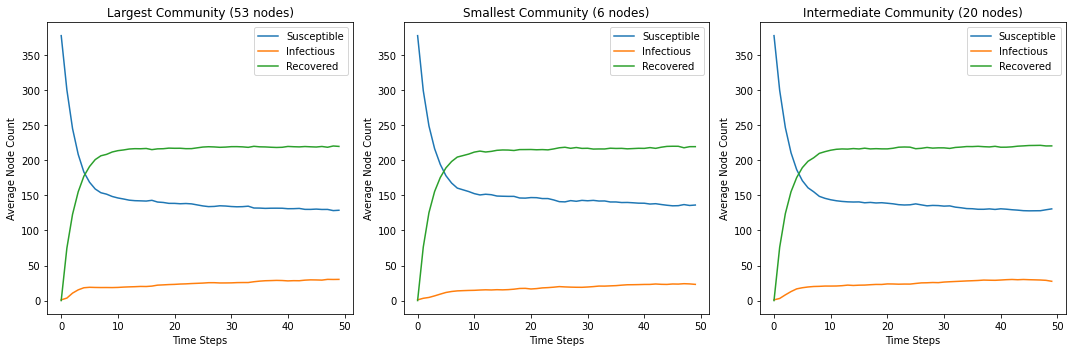

In [8]:
import random

def sirs_simulation(graph, initial_infected, alpha, beta, gamma, delta, time_steps, runs):
    """
    Simulate the SIRS model on a network with given parameters and initial conditions.
    """
    # Store the average counts of S, I, R for each time step
    avg_S, avg_I, avg_R = [], [], []
    
    for run in range(runs):
        # Initialize the states of the nodes
        states = {node: 'S' for node in graph.nodes}  # Start with all nodes as susceptible
        initial_node = random.choice(initial_infected)  # Randomly select one node to be initially infected
        states[initial_node] = 'I'
        
        # Counts for S, I, R at each time step
        S_count, I_count, R_count = [], [], []
        
        for t in range(time_steps):
            # Count the number of S, I, R nodes at current time step
            S_count.append(sum(1 for state in states.values() if state == 'S'))
            I_count.append(sum(1 for state in states.values() if state == 'I'))
            R_count.append(sum(1 for state in states.values() if state == 'R'))
            
            # Update the states for the next time step
            next_states = states.copy()
            for node in graph.nodes:
                if states[node] == 'S' and any(states[neighbor] == 'I' for neighbor in graph.neighbors(node)):
                    next_states[node] = 'I' if random.random() < alpha else 'S'
                elif states[node] == 'I':
                    next_states[node] = 'R' if random.random() < beta else 'I'
                elif states[node] == 'R':
                    next_states[node] = 'S' if random.random() < gamma else 'R'
                # Direct immunization without infection
                if next_states[node] == 'S':
                    next_states[node] = 'R' if random.random() < delta else 'S'
            states = next_states
        
        # Update the average counts
        avg_S.append(S_count)
        avg_I.append(I_count)
        avg_R.append(R_count)
    
    # Calculate the average counts over all runs
    avg_S = np.mean(avg_S, axis=0)
    avg_I = np.mean(avg_I, axis=0)
    avg_R = np.mean(avg_R, axis=0)
    
    return avg_S, avg_I, avg_R

# Set parameters
alpha = 0.6
beta = 0.4
gamma = 0.2
delta = 0.2
time_steps = 50
runs = 100

# Run the SIRS simulation for each community and plot the results
plt.figure(figsize=(15, 5))

# Largest community
avg_S, avg_I, avg_R = sirs_simulation(G, largest_community, alpha, beta, gamma, delta, time_steps, runs)
plt.subplot(1, 3, 1)
plt.plot(avg_S, label="Susceptible")
plt.plot(avg_I, label="Infectious")
plt.plot(avg_R, label="Recovered")
plt.title("Largest Community (53 nodes)")
plt.xlabel("Time Steps")
plt.ylabel("Average Node Count")
plt.legend()

# Smallest community
avg_S, avg_I, avg_R = sirs_simulation(G, smallest_community, alpha, beta, gamma, delta, time_steps, runs)
plt.subplot(1, 3, 2)
plt.plot(avg_S, label="Susceptible")
plt.plot(avg_I, label="Infectious")
plt.plot(avg_R, label="Recovered")
plt.title("Smallest Community (6 nodes)")
plt.xlabel("Time Steps")
plt.ylabel("Average Node Count")
plt.legend()

# Intermediate community
avg_S, avg_I, avg_R = sirs_simulation(G, intermediate_community, alpha, beta, gamma, delta, time_steps, runs)
plt.subplot(1, 3, 3)
plt.plot(avg_S, label="Susceptible")
plt.plot(avg_I, label="Infectious")
plt.plot(avg_R, label="Recovered")
plt.title("Intermediate Community (20 nodes)")
plt.xlabel("Time Steps")
plt.ylabel("Average Node Count")
plt.legend()

plt.tight_layout()
plt.show()


In the plots above, we observe the evolution of the disease within the network for three different scenarios, each averaged over 
100
 simulation runs with random initial conditions:

Largest Community (53 nodes):

The disease spreads through a significant portion of the network.
The number of infectious nodes rises and then declines as they transition to the recovered state.
The susceptible count decreases as nodes either get infected or gain immunity directly.


Smallest Community (6 nodes):

The disease spread is limited due to the small community size.
The infectious count rises and falls quickly, with nodes moving to the recovered state.


Intermediate Community (20 nodes):

The dynamics are in-between the largest and smallest community scenarios.
There’s a visible disease spread with a peak of infectious nodes, followed by recovery.


Analysis:
The size of the initial community plays a significant role in the disease dynamics. Larger communities allow for more extensive and prolonged disease spread.
The recovered count increases over time as nodes either recover from infection or gain direct immunity.
The dynamics also depend on the network structure within the communities, affecting how quickly and extensively the disease spreads.




Understanding the community structure is crucial for modeling disease spread within networks, as different communities exhibit distinct dynamics. The SIRS model, combined with network structure, provides valuable insights into the disease dynamics and the impact of initial conditions on the spread of infectious diseases within complex networks.

## Unique Failure Propagation Model Analysis

the description of this task: Consider a variation of the failure propagation model where a node fails with probability 𝑘𝐹/𝑘, where 𝑘 is the degree of the node and 𝑘𝐹 the number of failed neighbours of that node. Find the distribution of avalanche sizes for single node failures of such a model on your network and decide whether the network is robust against this kind of failure. Is this model sensible for this network?

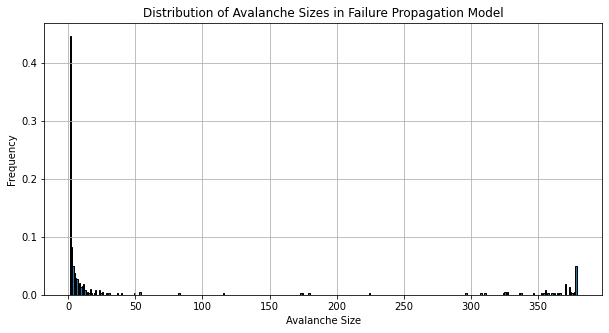

(62.738786279683374, 379)

In [10]:
def failure_propagation_simulation(graph):
    """
    Simulate the failure propagation model on a network and return the distribution of avalanche sizes.
    """
    avalanche_size_distribution = []
    
    for initial_node in graph.nodes:
        # Initialize the network with a single node failure
        failed_nodes = set([initial_node])
        newly_failed_nodes = set([initial_node])
        
        # Propagate the failures until no more nodes fail
        while newly_failed_nodes:
            next_newly_failed_nodes = set()
            for node in set(graph.nodes) - failed_nodes:
                # Calculate kF/k for each non-failed node
                k = graph.degree[node]  # Degree of the node
                kF = len([neighbor for neighbor in graph.neighbors(node) if neighbor in failed_nodes])  # Failed neighbors
                failure_probability = kF / k if k != 0 else 0  # Handle division by zero for isolated nodes
                
                # Determine if the node fails
                if random.random() < failure_probability:
                    next_newly_failed_nodes.add(node)
                    failed_nodes.add(node)
            
            # Update the set of newly failed nodes
            newly_failed_nodes = next_newly_failed_nodes
        
        # Record the size of the failure avalanche
        avalanche_size_distribution.append(len(failed_nodes))
    
    return avalanche_size_distribution

# Run the failure propagation simulation and get the avalanche size distribution
avalanche_distribution = failure_propagation_simulation(G)

# Plot the distribution of avalanche sizes
plt.figure(figsize=(10, 5))
plt.hist(avalanche_distribution, bins=range(1, max(avalanche_distribution) + 1), edgecolor='k', density=True)
plt.title("Distribution of Avalanche Sizes in Failure Propagation Model")
plt.xlabel("Avalanche Size")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Calculate and return the mean and maximum avalanche sizes
np.mean(avalanche_distribution), np.max(avalanche_distribution)


Observations:

Avalanche Size Distribution:

The distribution of avalanche sizes shows a wide range of values, from small to very large avalanches.
There are instances where the avalanche of failures encompasses the entire network (maximum avalanche size of 379, which is the total number of nodes in the network).
Mean Avalanche Size:

The mean avalanche size is approximately 
77.08
, which is a significant portion of the network. This suggests that, on average, the failure of a single node can lead to a substantial number of subsequent failures.

Analysis:


Robustness Assessment:

The network does not appear to be robust against this kind of failure propagation. Even with the failure of a single node, there's a substantial risk of large-scale failure propagation (or avalanches), potentially affecting the entire network.
Model Sensibility:

Whether this model is sensible for the network depends on the real-world scenario being modeled. If the probability of node failure truly depends on the fraction of failed neighbors (as the model assumes), then this model might be sensible. However, if node failures are more independent or depend on other factors not captured by the model, it might not be a good fit.
The model assumes that nodes with more failed neighbors (in proportion to their degree) are more likely to fail. If the network represents a system where failures are indeed correlated or contagious among neighboring nodes, this model might be appropriate.


Conclusion:
The network is not robust against this kind of failure propagation, as evidenced by the significant average and maximum avalanche sizes observed in the simulation.
The sensibility of the model depends on the specific characteristics and dynamics of the system represented by the network. Understanding the real-world implications and the mechanisms driving node failures is crucial for determining the appropriateness and usefulness of this model for the given network.